<a href="https://colab.research.google.com/github/Plumz17/PCD_Assignment03/blob/main/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Third Digital Image Processing Assignment
##Analysis of Morphological Processing Methods - Anders Emmanuel Tan (24/541351/PA/22964)

## 1. Setting Up Image to be Processed

In [ ]:
#Cloning Github Repository to get the Image
!rm -rf PCD_Assignment03
!git clone https://github.com/Plumz17/PCD_Assignment03

Cloning into 'PCD_Assignment03'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 1.56 MiB | 17.99 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# Import Important Libraries
import cv2 # For Reading Image
import numpy as np # For Manipulating Image Matrix
import matplotlib.pyplot as plt # For Showing Image
import math # For Math

filename = "/content/PCD_Assignment03/img.png"

img = cv2.imread(filename) # Read Image
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Change the color map

In [ ]:
def show(before, after=None, title1="Before", title2="After"): # Helper function to check the before and after of the enhancement
  plt.figure(figsize=(10,5))

   # Show original
  plt.subplot(1,2,1)
  plt.imshow(before, cmap='gray', vmin=0, vmax=255) #vmin and max to preserve original image's contrast
  plt.title(title1)
  plt.axis("off")

  # Show processed
  plt.subplot(1,2,2)
  plt.imshow(after, cmap='gray', vmin=0, vmax=255)
  plt.title(title2)
  plt.axis("off")

  plt.show()

In [ ]:
def negative(img): ## Negative Image
  out = img.copy()
  L = 256 # max pixel
  for i in range(out.shape[0]): #Iterate for every pixel in the x axis (Reminder that img.shape returns (width, height, channel))
    for j in range(out.shape[1]): #Iterate for every pixel in the y axis
      out[i][j] = L - 1 - out[i][j] # Use the formula s = (L - 1) - r, where L is 256 so s = 255 - r
  return out

negative_img = negative(img)

## 2. Image Segmentation

In [ ]:
def find_otsu_threshold(image):
  hist, bins = np.histogram(image.flatten(), 256, [0, 256]) #Make the PDF of the histogram
  totalPixel = image.size
  normilizedProb = hist / totalPixel # Normalize the histogram for easier calculation
  intensityLevels = np.arange(256)
  #Define used variables to minimize WCI
  minVariance = float("inf")
  optimalTreshold = 0

  #Loop over every single Threshold from 0 to 255
  for T in range(256):
    #Calculate Weight, Mean, and Variance of background
    wb = np.sum(normilizedProb[:T + 1])
    if wb == 0:
      continue
    meanb_up = np.sum(intensityLevels[:T + 1] * normilizedProb[:T + 1])
    meanb = meanb_up / wb
    varianceb_up = np.sum(normilizedProb[:T + 1] * (intensityLevels[:T + 1] - meanb)**2)
    varianceb = varianceb_up / wb

    #Calculate Weight, Mean, and Variance of foreground
    wf = np.sum(normilizedProb[T + 1:])
    if wf == 0:
      break

    meanf_up = np.sum(intensityLevels[T + 1:] * normilizedProb[T + 1:])
    meanf = meanf_up / wf
    variancef_up = np.sum(normilizedProb[T + 1:] * (intensityLevels[T + 1:] - meanf)**2)
    variancef = variancef_up / wf

    #Use Otsu Method Formula
    within_class_variance = wb * varianceb + wf * variancef

    #Override Threshold if more otpimal
    if within_class_variance < minVariance:
      minVariance = within_class_variance
      optimalTreshold = T
  return optimalTreshold



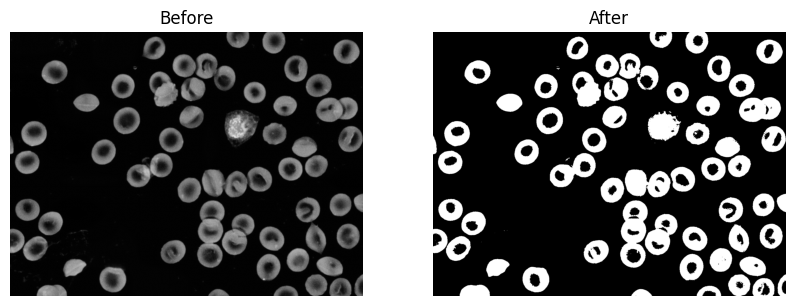

In [ ]:
def segment(image, threshold = 128):
  segmented_image = np.zeros(image.shape)
  row, col = image.shape

  for r in range(row):
    for c in range(col):
      if image[r,c] > threshold:
        segmented_image[r,c] = 255

  return segmented_image

segmented_img = segment(negative_img, find_otsu_threshold(negative_img))
show(negative_img, segment(negative_img, find_otsu_threshold(negative_img)))

## 3. Morphological Processes

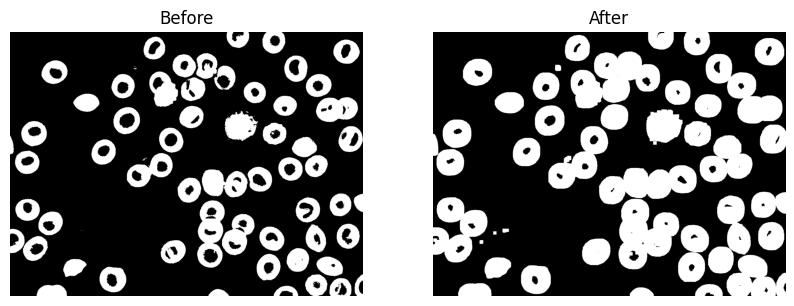

In [ ]:
def dilate(img, kernel_size = 3):
  rows, cols = img.shape
  dilated = np.zeros_like(img)
  kernel = np.ones((kernel_size, kernel_size), dtype=int)
  k_rows, k_cols = kernel.shape
  pad_rows, pad_cols = k_rows // 2, k_cols // 2 #Calculate padding amojnt

  padded = np.pad(img, ((pad_rows, pad_rows), (pad_cols, pad_cols)), mode='constant', constant_values=0) #Pad zero to the edge of the kernel
  for i in range(rows): #Process Every pixel
    for j in range(cols):
      region = padded[i:i+k_rows,j:j+k_cols] #Find Overlapped Region
      if np.any(region * kernel): #If region and kernel overlapped change background to foreground
        dilated[i, j] = 255
  return dilated

dilated_img = dilate(segmented_img, 15)
show(segmented_img, dilated_img)


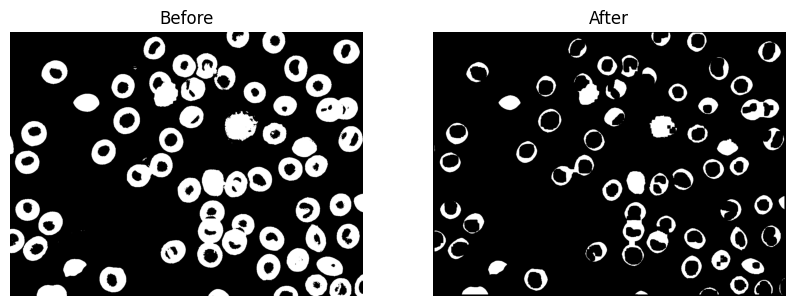

In [ ]:
def erode(img, kernel_size = 3):
  rows, cols = img.shape
  eroded = np.zeros_like(img)
  kernel = np.ones((kernel_size, kernel_size), dtype=int)
  k_rows, k_cols = kernel.shape
  pad_rows, pad_cols = k_rows // 2, k_cols // 2 #Calculate padding amojnt

  padded = np.pad(img, ((pad_rows, pad_rows), (pad_cols, pad_cols)), mode='constant', constant_values=0) #Pad zero to the edge of the kernel
  for i in range(rows): #Process Every pixel
    for j in range(cols):
      region = padded[i:i+k_rows,j:j+k_cols] #Find Overlapped Region
      if np.all(region * kernel == 255): #Change foreground to background if region is not in all of kernel
        eroded[i, j] = 255
      else:
        eroded[i, j] = 0
  return eroded

eroded_img = erode(segmented_img, 15)
show(segmented_img, eroded_img)


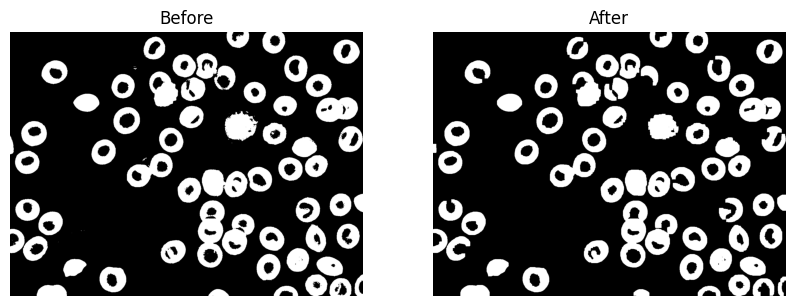

In [ ]:
def opening(img, kernel_size = 3):
  eroded = erode(img, kernel_size)
  opened = dilate(eroded, kernel_size)
  return opened

opened_img = opening(segmented_img, 15)
show(segmented_img, opened_img)

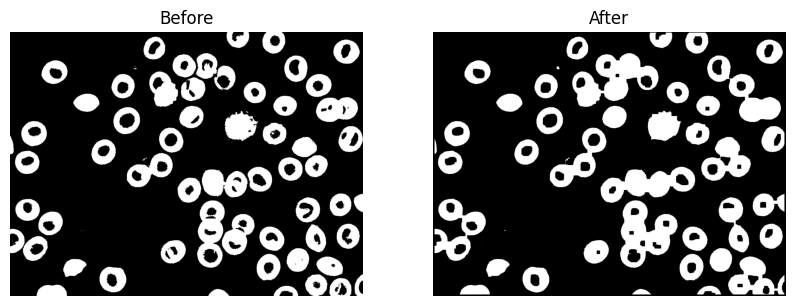

In [ ]:
def closing(img, kernel_size = 3):
  dilated = dilate(img, kernel_size)
  closed = erode(dilated, kernel_size)
  return closed

closed_img = closing(segmented_img, 15)
show(segmented_img, closed_img)